In [73]:
#load the data
import numpy as np 
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score


df = pd.read_csv("../classes/variabilites.csv")

N = 295 

df.head()


df['Ground_truth'].value_counts().to_frame().reset_index()

,Ground_truth,count
0,dead,151
1,alive,144


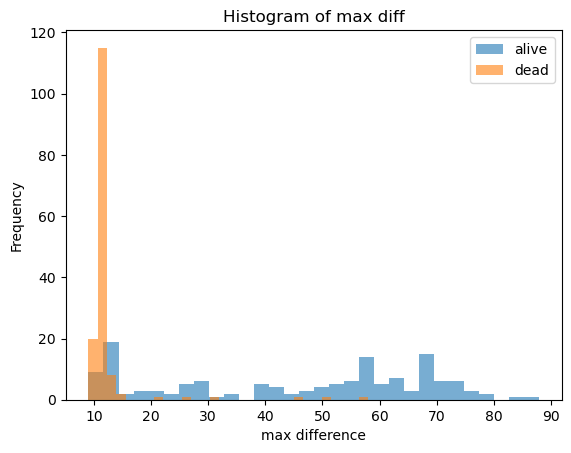

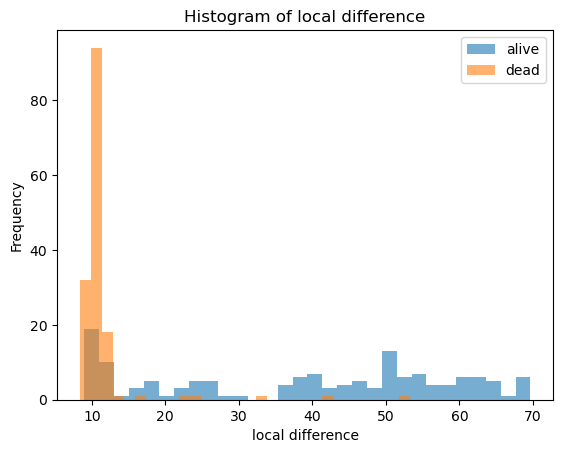

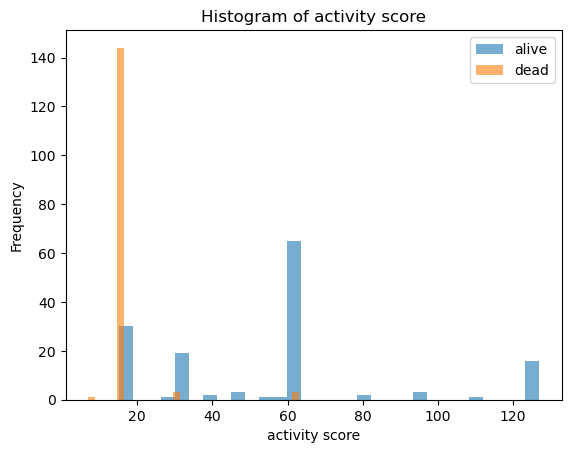

In [74]:
 # Plot histogram for each group (Alive True/False)
plt.figure()

for alive_status, group in df.groupby('Ground_truth'):
    plt.hist(group['max_diff'], bins=30, alpha=0.6, label=alive_status)


plt.xlabel('max difference')
plt.ylabel('Frequency')
plt.title('Histogram of max diff')
plt.legend()
plt.show()


for alive_status, group in df.groupby('Ground_truth'):
    plt.hist(group['local_diff'], bins=30, alpha=0.6, label=alive_status)


plt.xlabel('local difference')
plt.ylabel('Frequency')
plt.title('Histogram of local difference')
plt.legend()
plt.show()

for alive_status, group in df.groupby('Ground_truth'):
    plt.hist(group['activity_score'], bins=30, alpha=0.6, label=alive_status)


plt.xlabel('activity score')
plt.ylabel('Frequency')
plt.title('Histogram of activity score')
plt.legend()
plt.show()





# Threshold optimization

In [75]:
# validation, test split:


# Split data: 30% for threshold optimization, 70% for testing
df_val, df_test = train_test_split(df, test_size=0.5, stratify=df['Ground_truth'])




# ROC curve 

y_true = (df_val['Ground_truth'] == 'alive').astype(int).to_numpy()
y_scores_max_diff = df_val['max_diff'].to_numpy()
y_scores_local_diff = df_val['local_diff'].to_numpy()
y_scores_activity = df_val['activity_score'].to_numpy()

# ROC curves

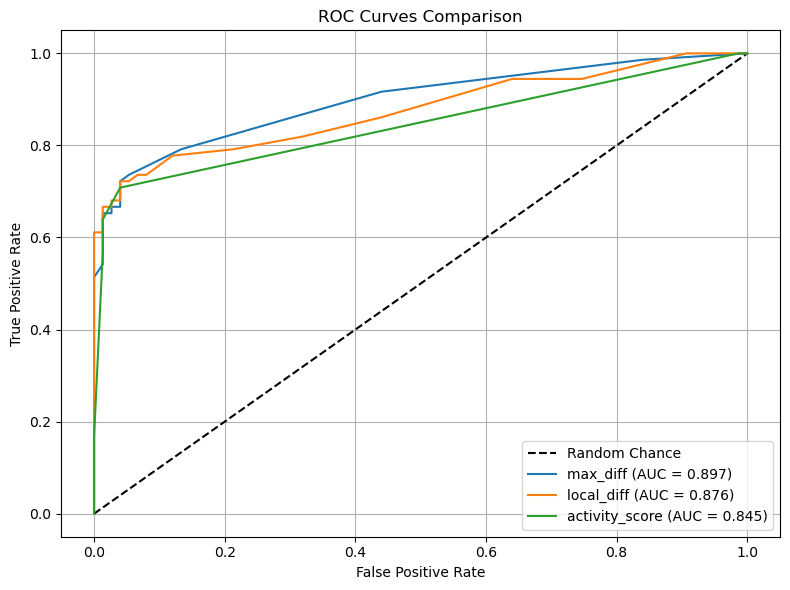

In [76]:
def plot_roc_curves(y_true, y_scores_dict):
    plt.figure(figsize=(8, 6))
    plt.title("ROC Curves Comparison")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

    for label, scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Usage example:
y_scores_dict = {
    'max_diff': y_scores_max_diff,
    'local_diff': y_scores_local_diff,
    'activity_score': y_scores_activity
}
plot_roc_curves(y_true, y_scores_dict)


C:\Users\mateo\AppData\Local\Temp\ipykernel_6208\618970651.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([thresholds_max_diff, thresholds_local_diff, thresholds_activity],


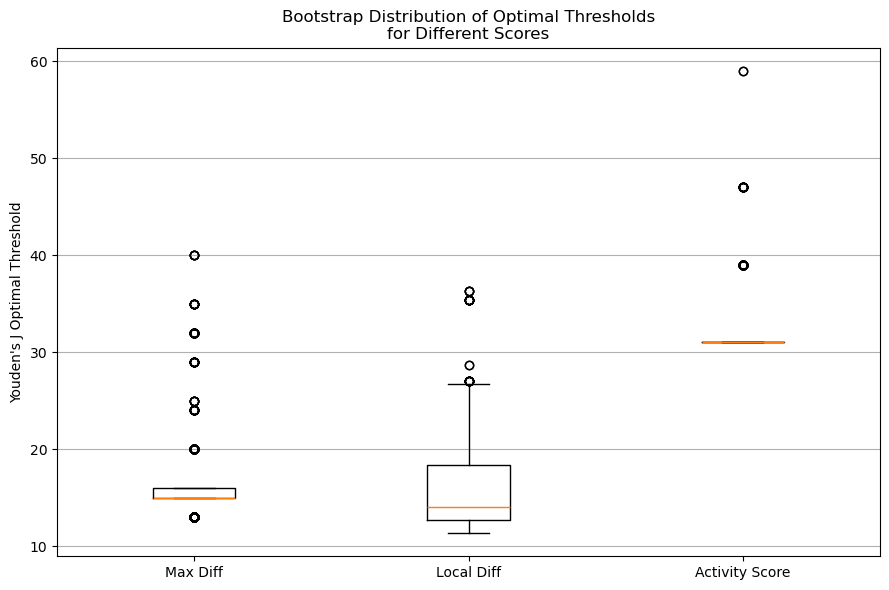

Mean threshold Max Diff: 16.908000
Mean threshold Local Diff: 15.941333
Mean threshold Activity Score: 31.992000


In [77]:
n_bootstraps = 1000
rng = np.random.default_rng(42)  # reproducible RNG

# y_true fixed, all y_scores from your data
# Example inputs:
# y_true = (df_val['Ground_truth'] == 'alive').astype(int).to_numpy()
# y_scores_max_diff = df_val['max_diff'].to_numpy()
# y_scores_local_diff = df_val['local_diff'].to_numpy()
# y_scores_activity = df_val['activity_score'].to_numpy()

thresholds_max_diff = []
thresholds_local_diff = []
thresholds_activity = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y_true), size=len(y_true), replace=True)

    y_true_sample = y_true[indices]

    y_scores_sample_max = y_scores_max_diff[indices]
    y_scores_sample_local = y_scores_local_diff[indices]
    y_scores_sample_activity = y_scores_activity[indices]

    for thresholds_list, y_scores_sample in zip(
        [thresholds_max_diff, thresholds_local_diff, thresholds_activity],
        [y_scores_sample_max, y_scores_sample_local, y_scores_sample_activity]
    ):
        fpr, tpr, thresholds = roc_curve(y_true_sample, y_scores_sample)
        j_scores = tpr - fpr
        if len(j_scores) == 0:
            continue
        best_idx = np.argmax(j_scores)
        best_thresh = thresholds[best_idx]
        thresholds_list.append(best_thresh)

# Plot all three boxplots side-by-side
plt.figure(figsize=(9, 6))
plt.boxplot([thresholds_max_diff, thresholds_local_diff, thresholds_activity], 
            labels=['Max Diff', 'Local Diff', 'Activity Score'])
plt.ylabel("Youden's J Optimal Threshold")
plt.title("Bootstrap Distribution of Optimal Thresholds\nfor Different Scores")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print mean thresholds
print(f"Mean threshold Max Diff: {np.mean(thresholds_max_diff):.6f}")
print(f"Mean threshold Local Diff: {np.mean(thresholds_local_diff):.6f}")
print(f"Mean threshold Activity Score: {np.mean(thresholds_activity):.6f}")



# classifier analysis

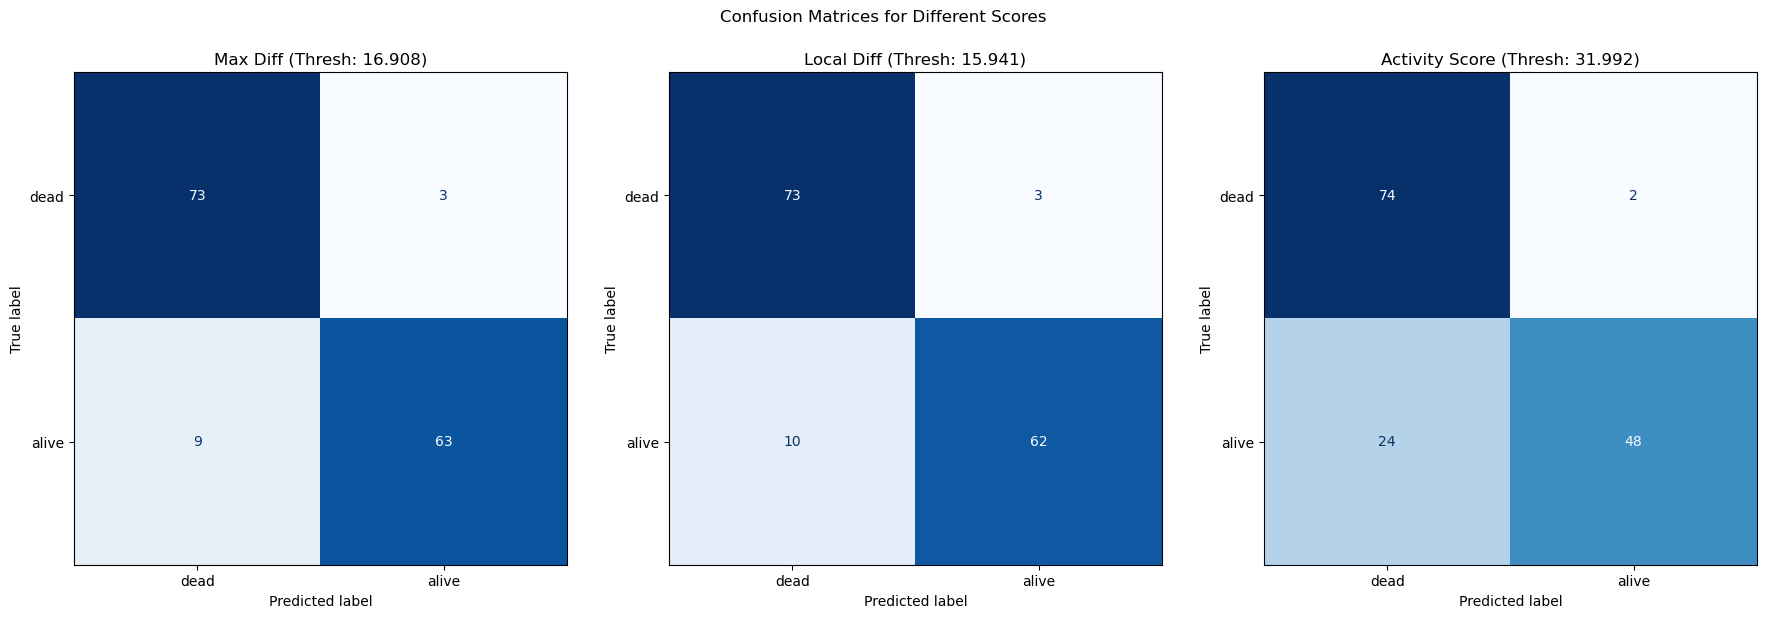

--- Max Diff ---
False Positive Rate (FPR): 0.039
False Negative Rate (FNR): 0.125
F1 Score: 0.913
Accuracy: 0.919

--- Local Diff ---
False Positive Rate (FPR): 0.039
False Negative Rate (FNR): 0.139
F1 Score: 0.905
Accuracy: 0.912

--- Activity Score ---
False Positive Rate (FPR): 0.026
False Negative Rate (FNR): 0.333
F1 Score: 0.787
Accuracy: 0.824



In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

# Assume best_thresh values for each score are computed previously, e.g.:
best_thresh_max = np.mean(thresholds_max_diff)
best_thresh_local = np.mean(thresholds_local_diff)
best_thresh_activity = np.mean(thresholds_activity)

# Convert Ground_truth to binary test labels
y_true_test = (df_test['Ground_truth'] == 'alive').astype(int)

# Predictions based on best thresholds for each score
y_pred_max = (df_test['max_diff'] > best_thresh_max).astype(int)
y_pred_local = (df_test['local_diff'] > best_thresh_local).astype(int)
y_pred_activity = (df_test['activity_score'] > best_thresh_activity).astype(int)

# Prepare subplot figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

scores = ['Max Diff', 'Local Diff', 'Activity Score']
y_preds = [y_pred_max, y_pred_local, y_pred_activity]
best_thresholds = [best_thresh_max, best_thresh_local, best_thresh_activity]

for i, ax in enumerate(axs):
    cm = confusion_matrix(y_true_test, y_preds[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["dead", "alive"])
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(f"{scores[i]} (Thresh: {best_thresholds[i]:.3f})")

plt.suptitle("Confusion Matrices for Different Scores")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optionally print stats for each
for i, y_pred in enumerate(y_preds):
    cm = confusion_matrix(y_true_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    f1 = f1_score(y_true_test, y_pred)
    accuracy = accuracy_score(y_true_test, y_pred)
    print(f"--- {scores[i]} ---")
    print(f"False Positive Rate (FPR): {fpr:.3f}")
    print(f"False Negative Rate (FNR): {fnr:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Accuracy: {accuracy:.3f}\n")


# Confidence intervals

C:\Users\mateo\AppData\Local\Temp\ipykernel_6208\3780986909.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracies_all, labels=scores.keys())
C:\Users\mateo\AppData\Local\Temp\ipykernel_6208\3780986909.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fprs_all, labels=scores.keys())
C:\Users\mateo\AppData\Local\Temp\ipykernel_6208\3780986909.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fnrs_all, labels=scores.keys())


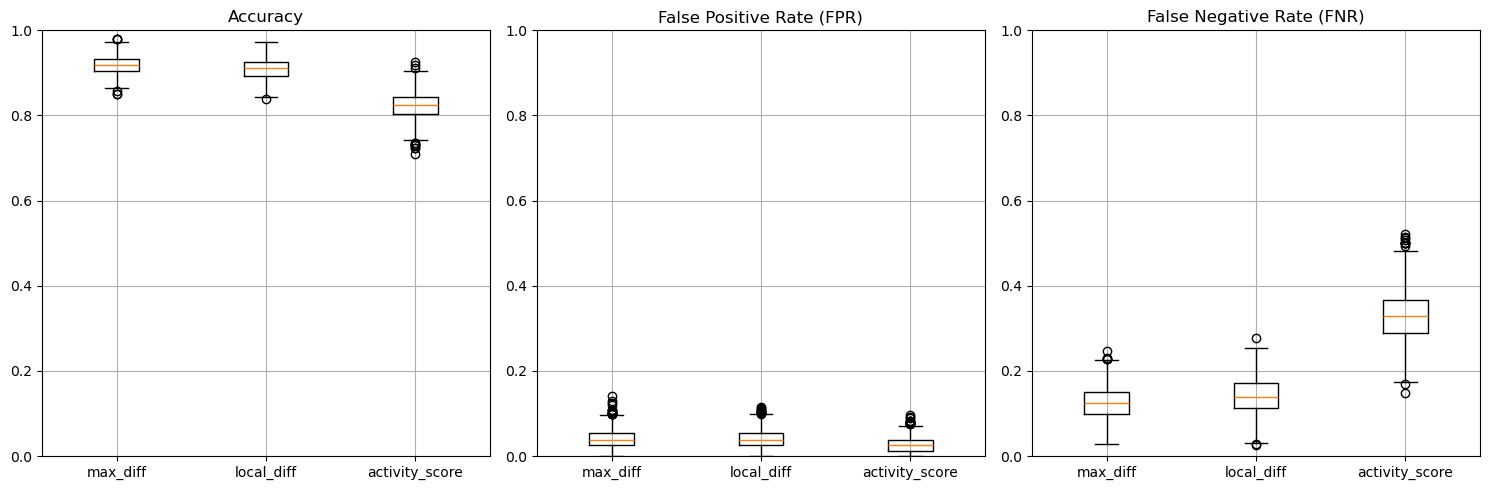

max_diff:
  Mean Accuracy: 0.9183
  Mean FPR: 0.0403
  Mean FNR: 0.1259

local_diff:
  Mean Accuracy: 0.9107
  Mean FPR: 0.0408
  Mean FNR: 0.1408

activity_score:
  Mean Accuracy: 0.8261
  Mean FPR: 0.0261
  Mean FNR: 0.3296



In [79]:
n_bootstraps = 1000
rng = np.random.default_rng(42)

# Scores and thresholds (replace with your actual best thresholds)
scores = {
    'max_diff': df_test['max_diff'].values,
    'local_diff': df_test['local_diff'].values,
    'activity_score': df_test['activity_score'].values
}

best_thresholds = {
    'max_diff': best_thresh_max,
    'local_diff': best_thresh_local,
    'activity_score': best_thresh_activity
}

y_true = (df_test['Ground_truth'] == 'alive').astype(int).values

# Prepare containers for metrics of each score
accuracies_all = []
fprs_all = []
fnrs_all = []

for score_name, y_scores in scores.items():
    threshold = best_thresholds[score_name]
    y_pred = (y_scores > threshold).astype(int)

    accuracies = []
    fprs = []
    fnrs = []

    for _ in range(n_bootstraps):
        indices = rng.integers(0, len(y_true), size=len(y_true))
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]

        tn, fp, fn, tp = confusion_matrix(y_true_sample, y_pred_sample).ravel()

        acc = (tp + tn) / (tp + tn + fp + fn)
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr_val = fn / (fn + tp) if (fn + tp) > 0 else 0

        accuracies.append(acc)
        fprs.append(fpr_val)
        fnrs.append(fnr_val)

    accuracies_all.append(accuracies)
    fprs_all.append(fprs)
    fnrs_all.append(fnrs)

# Plotting
plt.figure(figsize=(15, 5))

# Accuracy subplot
plt.subplot(1, 3, 1)
plt.boxplot(accuracies_all, labels=scores.keys())
plt.title("Accuracy")
plt.ylim(0, 1)
plt.grid(True)

# FPR subplot
plt.subplot(1, 3, 2)
plt.boxplot(fprs_all, labels=scores.keys())
plt.title("False Positive Rate (FPR)")
plt.ylim(0, 1)
plt.grid(True)

# FNR subplot
plt.subplot(1, 3, 3)
plt.boxplot(fnrs_all, labels=scores.keys())
plt.title("False Negative Rate (FNR)")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

# Optionally print mean values for each metric and score
for i, score_name in enumerate(scores.keys()):
    print(f"{score_name}:")
    print(f"  Mean Accuracy: {np.mean(accuracies_all[i]):.4f}")
    print(f"  Mean FPR: {np.mean(fprs_all[i]):.4f}")
    print(f"  Mean FNR: {np.mean(fnrs_all[i]):.4f}\n")